# Requirements

In [207]:
import pandas as pd
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Add as many imports as you need.

# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the focus is on time series forecasting, specifically targeting the prediction of the current **mean temperature** in the city of Delhi. Your task involves employing bagging and boosting methods to forecast the **mean temperature**. To accomplish this use data from the preceding three days, consisting of **mean temperature**, **humidity**, **wind speed**, and **mean pressure**.

**Note: You are required to perform this laboratory assignment on your local machine.**

## The Climate Dataset

## Downloading the Climate Dataset

In [1]:
!gdown 1kczX2FpFTH1QEsDeg6dszXM3Azwyd7XC # Download the dataset.

usage: gdown [-h] [-V] [-O OUTPUT] [-q] [--fuzzy] [--id] [--proxy PROXY]
             [--speed SPEED] [--no-cookies] [--no-check-certificate]
             [--continue] [--folder] [--remaining-ok] [--format FORMAT]
             [--user-agent USER_AGENT]
             url_or_id
gdown: error: unrecognized arguments: # Download the dataset.


## Exploring the Climate Dataset
This dataset consists of daily weather records for the city of Delhi spanning a period of 4 years (from 2013 to 2017). The dataset includes the following attributes:

- date - date in the format YYYY-MM-DD,
- meantemp - mean temperature averaged from multiple 3-hour intervals in a day,
- humidity - humidity value for the day (measured in grams of water vapor per cubic meter volume of air),
- wind_speed - wind speed measured in kilometers per hour, and
- meanpressure - pressure reading of the weather (measured in atm).

*Note: The dataset is complete, with no missing values in any of its entries.*

Load the dataset into a `pandas` data frame.

In [5]:
data = pd.read_csv('climate-data.csv')

In [21]:
data

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


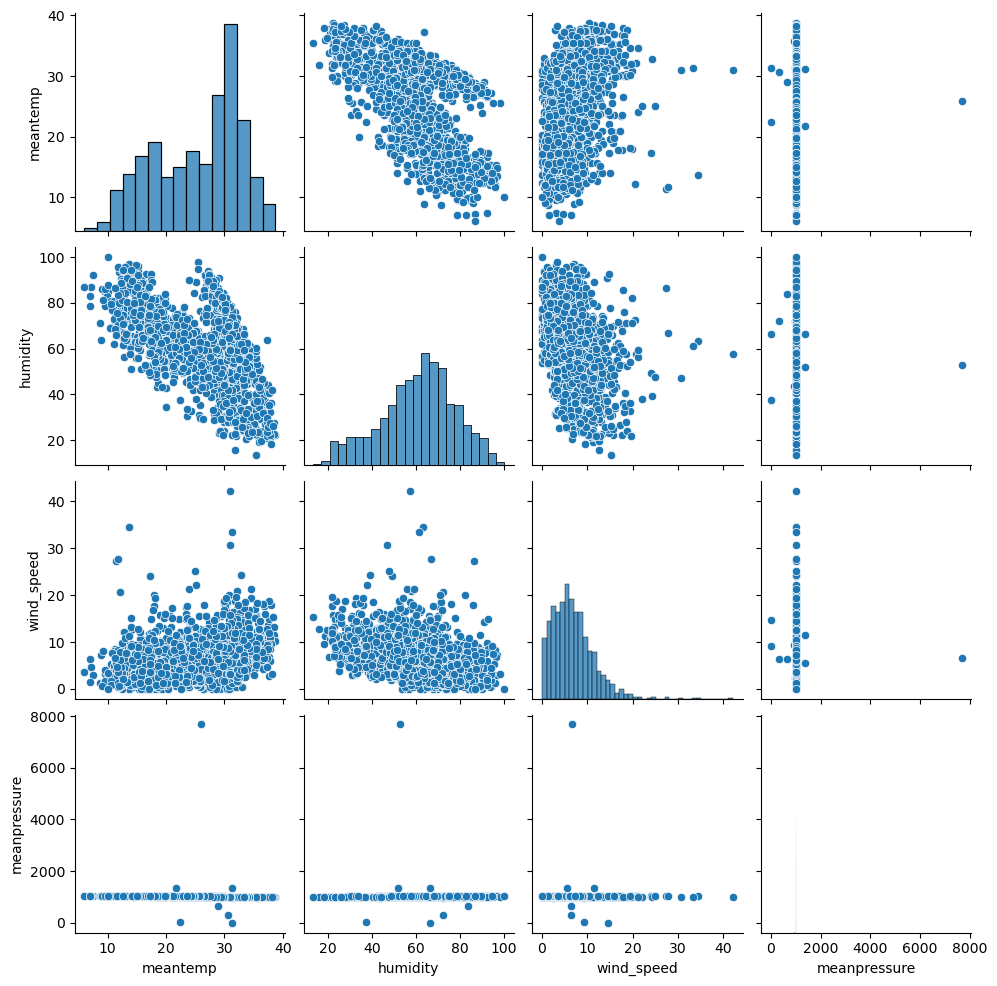

In [15]:
sns.pairplot(data)

Explore the dataset using visualizations of your choice.

# Feauture Extraction
Apply a lag of one, two, and three days to each feature, creating a set of features representing the meteorological conditions from the previous three days. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [31]:
newdata = data.shift(periods=3)

In [39]:
data = pd.concat([newdata[0:3], data], ignore_index=True)

In [61]:
data[0:15]['meantemp'].mean()

9.73373015873016

In [65]:
data.head(20)

,date,meantemp,humidity,wind_speed,meanpressure
0,None,NaN,NaN,NaN,NaN
1,None,NaN,NaN,NaN,NaN
2,None,NaN,NaN,NaN,NaN
3,2013-01-01,10.000000,84.500000,0.000000,1015.666667
4,2013-01-02,7.400000,92.000000,2.980000,1017.800000
5,2013-01-03,7.166667,87.000000,4.633333,1018.666667
6,2013-01-04,8.666667,71.333333,1.233333,1017.166667
7,2013-01-05,6.000000,86.833333,3.700000,1016.500000
8,2013-01-06,7.000000,82.800000,1.480000,1018.000000
9,2013-01-07,7.000000,78.600000,6.300000,1020.000000


In [69]:
data['meantemp'] = data['meantemp'].fillna(value=data[0:15]['meantemp'].mean())

In [71]:
data['humidity'] = data['humidity'].fillna(value=data[0:15]['humidity'].mean())

In [73]:
data['wind_speed'] = data['wind_speed'].fillna(value=data[0:15]['wind_speed'].mean())

In [75]:
data['meanpressure'] = data['meanpressure'].fillna(value=data[0:15]['meanpressure'].mean())

In [87]:
data['date'] = pd.to_datetime(data['date'])

In [111]:
pd.to_datetime('2012-12-29')

Timestamp('2012-12-29 00:00:00')

In [129]:
first_valid_date = data['date'].dropna().iloc[0]
missing_dates = pd.date_range(end=first_valid_date - pd.Timedelta(days=1), periods=3).sort_values()

In [137]:
data.loc[:2, 'date'] = missing_dates

In [165]:
data = data.set_index('date')

In [179]:
def createFeatures(data):
    data['dayofweek'] = data.index.day_of_week
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['dayofyear'] = data.index.dayofyear
    return data

In [181]:
data = createFeatures(data)

In [185]:
data

,meantemp,humidity,wind_speed,meanpressure,dayofweek,month,year,dayofyear
date,,,,,,,,
2012-12-29,9.733730,73.776389,5.930794,1017.241270,5,12,2012,364
2012-12-30,9.733730,73.776389,5.930794,1017.241270,6,12,2012,365
2012-12-31,9.733730,73.776389,5.930794,1017.241270,0,12,2012,366
2013-01-01,10.000000,84.500000,0.000000,1015.666667,1,1,2013,1
2013-01-02,7.400000,92.000000,2.980000,1017.800000,2,1,2013,2
...,...,...,...,...,...,...,...,...
2016-12-28,17.217391,68.043478,3.547826,1015.565217,2,12,2016,363
2016-12-29,15.238095,87.857143,6.000000,1016.904762,3,12,2016,364
2016-12-30,14.095238,89.666667,6.266667,1017.904762,4,12,2016,365


## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [187]:
X = data.drop('meantemp', axis=1)
y = data['meantemp']

X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.2, shuffle=False)

## Ensemble Learning Methods

### Bagging

Create an instance of a Random Forest model and train it using the `fit` function.

In [199]:
rfm = RandomForestRegressor(verbose=True)

In [201]:
rfm.fit(X_train, Y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


RandomForestRegressor(verbose=True)

Use the trained model to make predictions for the test set.

In [203]:
rfm.score(X_test, Y_test)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


0.7956242121428843

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [ ]:
# Write your code here. Add as many boxes as you need.

### Boosting

Create an instance of an XGBoost model and train it using the `fit` function.

In [231]:
reg = XGBRegressor(n_estimators=1000, early_stopping_rounds = 50)

In [233]:
reg.fit(X_train, Y_train,
       eval_set=[(X_train, Y_train), (X_test, Y_test)],
       verbose=10)

[0]	validation_0-rmse:5.40696	validation_1-rmse:5.67667
[10]	validation_0-rmse:0.88929	validation_1-rmse:2.51036
[20]	validation_0-rmse:0.64697	validation_1-rmse:2.45116
[30]	validation_0-rmse:0.51488	validation_1-rmse:2.43389
[40]	validation_0-rmse:0.43309	validation_1-rmse:2.43133
[50]	validation_0-rmse:0.35909	validation_1-rmse:2.56574
[60]	validation_0-rmse:0.30245	validation_1-rmse:2.61609
[70]	validation_0-rmse:0.26170	validation_1-rmse:2.62166
[80]	validation_0-rmse:0.22302	validation_1-rmse:2.62305
[83]	validation_0-rmse:0.20920	validation_1-rmse:2.61308


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Use the trained model to make predictions for the test set.

In [235]:
reg.predict(X_test)

array([24.087862, 25.064991, 25.84684 , 24.049612, 24.087255, 25.283096,
       26.68873 , 25.863144, 27.098904, 26.931768, 26.628448, 24.73155 ,
       26.519094, 21.447763, 26.706516, 26.255857, 26.546423, 26.529207,
       26.535385, 27.103878, 28.112055, 28.848612, 28.87009 , 28.348412,
       27.026457, 27.550009, 28.727297, 27.639427, 30.14532 , 31.189146,
       31.050436, 31.443926, 31.225113, 32.43939 , 31.948912, 31.520864,
       30.68118 , 32.82809 , 33.43873 , 33.1922  , 32.493145, 33.043808,
       32.09309 , 32.525513, 33.103607, 33.42256 , 33.433304, 33.382427,
       33.414467, 32.47649 , 32.236115, 30.919846, 30.849812, 32.108326,
       31.800325, 31.54663 , 30.828478, 29.251122, 31.816107, 33.73564 ,
       32.798912, 32.911293, 35.279305, 36.431164, 37.146072, 34.79174 ,
       34.377724, 34.694805, 35.266193, 33.32506 , 32.21163 , 34.24445 ,
       33.78317 , 36.21205 , 34.534573, 31.364046, 27.43012 , 30.849909,
       32.13713 , 33.213757, 32.708565, 33.587616, 

In [242]:
reg.feature_importances_

array([0.03029525, 0.00502711, 0.8181302 , 0.00373645, 0.02128951,
       0.02193626, 0.09958511], dtype=float32)

In [244]:
pd.DataFrame(data=reg.feature_importances_,
            index=reg.feature_names_in_)

,0
humidity,0.030295
wind_speed,0.005027
meanpressure,0.818130
dayofweek,0.003736
month,0.021290
year,0.021936
dayofyear,0.099585


Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

<Axes: ylabel='date'>

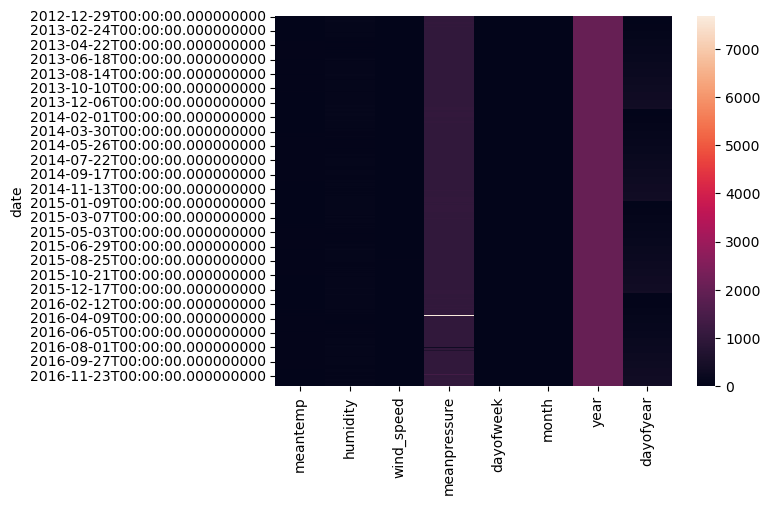

In [248]:
sns.heatmap(data)

In [ ]:
# Write your code here. Add as many boxes as you need.

# Laboratory Exercise - Bonus Task (+ 2 points)

Define the forecasting model using the **Keras Sequential API** (`keras.models.Sequential`), incorporating one or more LSTM layers along with additional relevant layers (`keras.layers`). Be cautious when specifying the configuration of the final layer to ensure proper model output for the forecasting task.